In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import openml
from category_encoders import LeaveOneOutEncoder, CatBoostEncoder
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import ClassificationExperiment
from pycaret.datasets import get_data

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

from ydata_profiling import ProfileReport

from earlymed import LearningCurve, FeatureCurve, FeatureLearningPlot

In [2]:
full_data = get_data('../data/diabetes/diabetes')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
full_data.shape

(768, 9)

In [4]:
data, _ = train_test_split(full_data, train_size=200, random_state=42)

In [5]:
profile = ProfileReport(data, title="Pandas Profiling Report", minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 197 to 102
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               200 non-null    int64  
 1   Glucose                   200 non-null    int64  
 2   BloodPressure             200 non-null    int64  
 3   SkinThickness             200 non-null    int64  
 4   Insulin                   200 non-null    int64  
 5   BMI                       200 non-null    float64
 6   DiabetesPedigreeFunction  200 non-null    float64
 7   Age                       200 non-null    int64  
 8   Outcome                   200 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 15.6 KB


In [7]:
n_classes = data['Outcome'].unique().size

---
### CatBoostEncoder

In [8]:
exp = ClassificationExperiment()
exp.setup(
    data,
    target='Outcome',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

,Description,Value
0,Session id,42
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(200, 9)"
4,Transformed data shape,"(200, 9)"
5,Transformed train set shape,"(140, 9)"
6,Transformed test set shape,"(60, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [9]:
best = exp.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7286,0.7500,0.4400,0.6850,0.5017,0.3385,0.3704,0.0190
ridge,Ridge Classifier,0.7286,0.7522,0.4400,0.6850,0.5017,0.3385,0.3704,0.0190
rf,Random Forest Classifier,0.6857,0.7125,0.4550,0.6117,0.4834,0.2726,0.2978,0.0780
knn,K Neighbors Classifier,0.6714,0.6140,0.3500,0.5783,0.4125,0.2103,0.2333,0.0180
et,Extra Trees Classifier,0.6643,0.7112,0.3150,0.5352,0.3549,0.1783,0.2074,0.0610
lightgbm,Light Gradient Boosting Machine,0.6643,0.6906,0.4700,0.5917,0.4815,0.2452,0.2715,0.0270
gbc,Gradient Boosting Classifier,0.6571,0.6692,0.4600,0.5719,0.4791,0.2358,0.2557,0.0680
svm,SVM - Linear Kernel,0.6429,0.6742,0.4450,0.4290,0.4248,0.1916,0.1951,0.0150
ada,Ada Boost Classifier,0.6286,0.6400,0.4150,0.5008,0.4198,0.1602,0.1785,0.0580
catboost,CatBoost Classifier,0.6214,0.6961,0.3500,0.5205,0.3792,0.1266,0.1528,0.4920


In [10]:
best = exp.create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7857,0.8000,0.7500,0.6000,0.6667,0.5116,0.5185
1,0.6429,0.5000,0.2500,0.3333,0.2857,0.0541,0.0550
2,0.7857,0.6667,0.8000,0.6667,0.7273,0.5532,0.5594
3,0.8571,0.8889,0.6000,1.0000,0.7500,0.6585,0.7006
4,0.7857,0.8000,0.6000,0.7500,0.6667,0.5116,0.5185
5,0.7857,0.9778,0.4000,1.0000,0.5714,0.4615,0.5477
6,0.6429,0.5111,0.2000,0.5000,0.2857,0.1026,0.1217
7,0.6429,0.8000,0.2000,0.5000,0.2857,0.1026,0.1217
8,0.7143,1.0000,0.2000,1.0000,0.3333,0.2432,0.3721


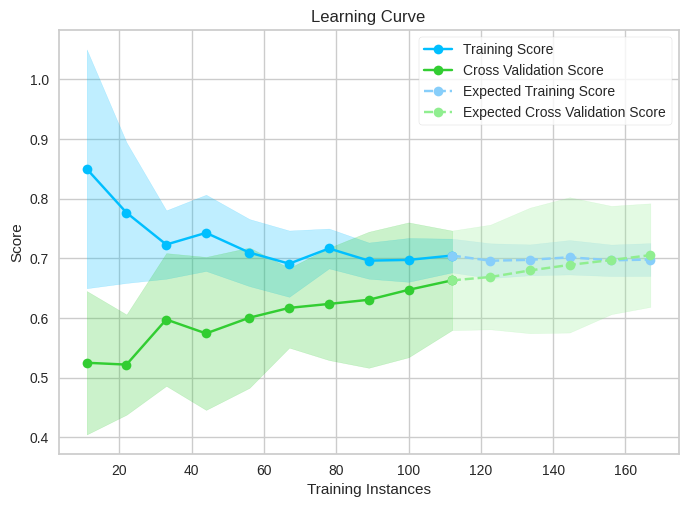

In [11]:
lc = LearningCurve(best)
lc.fit(exp.X_train_transformed, exp.y_train_transformed)

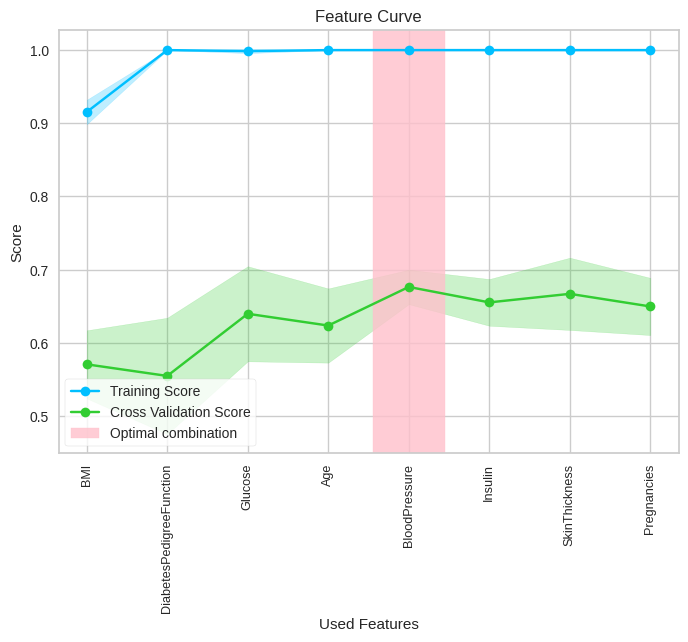

In [12]:
fc = FeatureCurve(best, n_hints=1, features_order=['BMI', 'DiabetesPedigreeFunction', 'Glucose', 'Age', 'BloodPressure', 'Insulin', 'SkinThickness', 'Pregnancies'])
fc.fit(exp.X_train_transformed, exp.y_train_transformed)

CPU times: user 1.34 s, sys: 11.8 ms, total: 1.36 s
Wall time: 1.36 s


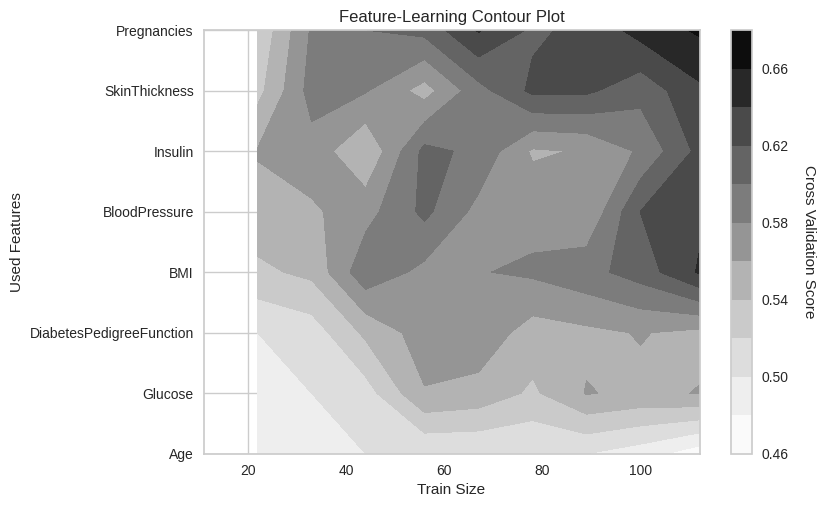

In [13]:
%%time
flc = FeatureLearningPlot(best)
flc.fit(exp.X_train_transformed, exp.y_train_transformed)

---
### TabEBM with CatBoostEncoder

In [14]:
from tabebm.TabEBM import TabEBM

In [15]:
tabebm = TabEBM(plotting=False)
augmented_data = tabebm.generate(exp.X_train_transformed.values, exp.y_train_transformed.values, num_samples=500//n_classes)

In [16]:
X_syn = np.concatenate(list(augmented_data.values()))
y_syn = np.concatenate([np.full(len(augmented_data[f"class_{i}"]), i) for i in range(len(augmented_data.keys()))])
X_train_augmented = np.concatenate([exp.X_train_transformed, X_syn])
y_train_augmented = np.concatenate([exp.y_train_transformed, y_syn])

In [17]:
best.fit(exp.X_train_transformed, exp.y_train_transformed)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.65527950310559

In [18]:
best.fit(X_train_augmented, y_train_augmented)
balanced_accuracy_score(best.predict(exp.X_test_transformed), exp.y_test_transformed)

0.6527614571092832

---
### Full data experiement

In [19]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data,
    target='Outcome',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

,Description,Value
0,Session id,42
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


In [20]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7784,0.8291,0.5819,0.7369,0.6397,0.4851,0.4994,0.0210
ridge,Ridge Classifier,0.7747,0.8304,0.5661,0.7344,0.6297,0.4740,0.4883,0.0160
catboost,CatBoost Classifier,0.7579,0.8204,0.5664,0.6888,0.6118,0.4410,0.4526,0.7500
et,Extra Trees Classifier,0.7524,0.8100,0.5605,0.6824,0.5995,0.4275,0.4427,0.0800
gbc,Gradient Boosting Classifier,0.7449,0.8169,0.5398,0.6773,0.5874,0.4096,0.4239,0.1110
rf,Random Forest Classifier,0.7412,0.8111,0.5453,0.6626,0.5903,0.4057,0.4150,0.1030
ada,Ada Boost Classifier,0.7336,0.7854,0.5398,0.6396,0.5749,0.3865,0.3961,0.0650
knn,K Neighbors Classifier,0.7319,0.7595,0.5284,0.6547,0.5724,0.3834,0.3952,0.0190
lightgbm,Light Gradient Boosting Machine,0.7244,0.7892,0.5503,0.6273,0.5791,0.3773,0.3840,0.0350
xgboost,Extreme Gradient Boosting,0.7168,0.7758,0.5716,0.6062,0.5825,0.3702,0.3747,0.0470


---
Let's test the hypotise that only some features are enough for an accurate classifier

In [21]:
exp_full = ClassificationExperiment()
exp_full.setup(
    full_data[['Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'BloodPressure', 'Outcome']],
    target='Outcome',
    session_id=42,
    preprocess=True,
    imputation_type='simple',
    normalize=True,
    normalize_method='zscore',
    encoding_method=CatBoostEncoder(),
    max_encoding_ohe=2,
    n_jobs=1
)

,Description,Value
0,Session id,42
1,Target,Outcome
2,Target type,Binary
3,Original data shape,"(768, 5)"
4,Transformed data shape,"(768, 5)"
5,Transformed train set shape,"(537, 5)"
6,Transformed test set shape,"(231, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [22]:
best_full = exp_full.compare_models(exclude=['lda', 'dummy', 'nb', 'qda'], cross_validation=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7820,0.8234,0.5816,0.7392,0.6425,0.4911,0.5039,0.0160
ridge,Ridge Classifier,0.7764,0.8221,0.5605,0.7364,0.6272,0.4745,0.4893,0.0160
ada,Ada Boost Classifier,0.7596,0.7953,0.5658,0.6901,0.6126,0.4435,0.4546,0.0630
catboost,CatBoost Classifier,0.7522,0.8220,0.5754,0.6678,0.6058,0.4306,0.4416,0.5870
gbc,Gradient Boosting Classifier,0.7467,0.8104,0.5497,0.6800,0.5930,0.4155,0.4299,0.0850
rf,Random Forest Classifier,0.7448,0.8010,0.5705,0.6538,0.5987,0.4161,0.4250,0.1050
knn,K Neighbors Classifier,0.7356,0.7730,0.5330,0.6489,0.5750,0.3891,0.3989,0.0180
lightgbm,Light Gradient Boosting Machine,0.7335,0.7817,0.5751,0.6307,0.5937,0.3980,0.4047,0.0340
et,Extra Trees Classifier,0.7317,0.7991,0.5702,0.6228,0.5845,0.3907,0.3990,0.0750
xgboost,Extreme Gradient Boosting,0.7241,0.7727,0.5696,0.6091,0.5836,0.3793,0.3826,0.0470
